In [28]:
from rank_bm25 import BM25Okapi
import nltk
import re
import pickle
import pandas as pd
import numpy as np
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn import metrics
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import helper.sklearn_to_csv

In [29]:
COL_OPINION = 0
COL_SPEECH = 8

RUNS = 100
TEST_SPLIT = 0.15
SHUFFLE = True
STRATIFY = True
CLASS_WEIGHTS = False
REMOVE_STOP_WORDS = True
STEMMING = False
LOWERING = False
NO_PUNCTUATION = True

N_BEST = 3

OUT_NAME = f'measures_bm25_01_{TEST_SPLIT}_Shuff{SHUFFLE}_Strat{STRATIFY}_Weigh{CLASS_WEIGHTS}_NoStop{REMOVE_STOP_WORDS}_Stem{STEMMING}_Low{LOWERING}_NoPun{NO_PUNCTUATION}_Nbest{N_BEST}'
PATH_METRICS = f'../results/{OUT_NAME}.csv'
PATH_DATASET = "../protocols/labelled/massnahmen_relevant.csv"
PATH_PERFORMANCE_GRAPH = f'../results/{OUT_NAME}.png'

In [30]:
# read data from csv
data = pd.read_csv(PATH_DATASET, sep='\t', header=None, skiprows=[0])

# Create binary grade, class 1-2 or 5-6  = good or bad
data["opinion_integer"] = 0
data.loc[data[COL_OPINION] == '-', "opinion_integer"] = 0
data.loc[data[COL_OPINION] == 'o', "opinion_integer"] = 1
data.loc[data[COL_OPINION] == '+', "opinion_integer"] = 2

In [31]:
nltk.download("stopwords")
nltk.download("punkt")
stemmer = SnowballStemmer("german")
stop_words = set(stopwords.words("german"))

def clean_text(text):
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>")
    if NO_PUNCTUATION:
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
    else:
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž,.!? ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž,.!?]\b", re.IGNORECASE)

    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)

    tokenizer = nltk.RegexpTokenizer(r"\w+")
    word_tokens = tokenizer.tokenize(text)
    if LOWERING:
        word_tokens = [word.lower() for word in word_tokens]
    else:
        word_tokens = [word for word in word_tokens]

    if REMOVE_STOP_WORDS:
        word_tokens = [word for word in word_tokens if word not in stop_words]

    if STEMMING:
        word_tokens = [stemmer.stem(word) for word in word_tokens]

    return ' '.join(word_tokens)

[nltk_data] Downloading package stopwords to /home/stefan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/stefan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [32]:
%%time
# Clean Comments
data["comment_clean"] = data.loc[data[COL_SPEECH].str.len() > 1, COL_SPEECH]
data["comment_clean"] = data["comment_clean"].map(
    lambda x: clean_text(x) if isinstance(x, str) else x
)

CPU times: user 561 ms, sys: 0 ns, total: 561 ms
Wall time: 559 ms


In [33]:
# Drop Missing
data = data.dropna(axis="index", subset=["opinion_integer", "comment_clean"]).reset_index(
    drop=True
)
data = data[["comment_clean", "opinion_integer"]]
data.columns = ["text", "label"]
data.head(2)

,text,label
0,Die Tourismusleistungen derartig gut Österreic...,2
1,Da nämlich schon Rede davon jemand überlegt be...,0


In [34]:
def split_df(df, split_number):
    return df[:split_number], df[split_number:]

def corpus_split_even(holdback_per_class):
    train = pd.DataFrame()
    test = pd.DataFrame()

    for i in range(3):
        rows_with_class = data[data['label'] == i]
        if SHUFFLE:
            rows_with_class = rows_with_class.sample(frac=1).reset_index(drop=True)
        l, r = split_df(rows_with_class, holdback_per_class)
        train = train.append(r, ignore_index=True)
        test = test.append(l, ignore_index=True)

    if SHUFFLE:
        train = train.sample(frac=1).reset_index(drop=True)
        test = test.sample(frac=1).reset_index(drop=True)

    train_x = train['text'].tolist()
    test_x = test['text'].tolist()
    train_y = train['label'].tolist()
    test_y = test['label'].tolist()

    return train_x, test_x, train_y, test_y

def corpus_split_stratified(test_split=TEST_SPLIT):
    train = pd.DataFrame()
    test = pd.DataFrame()

    for i in range(3):
        rows_with_class = data[data['label'] == i]
        if SHUFFLE:
            rows_with_class = rows_with_class.sample(frac=1).reset_index(drop=True)
        split_for_class = int(test_split * len(rows_with_class))
        l, r = split_df(rows_with_class, split_for_class)
        train = train.append(r, ignore_index=True)
        test = test.append(l, ignore_index=True)

    if SHUFFLE:
        train = train.sample(frac=1).reset_index(drop=True)
        test = test.sample(frac=1).reset_index(drop=True)

    train_x = train['text'].tolist()
    test_x = test['text'].tolist()
    train_y = train['label'].tolist()
    test_y = test['label'].tolist()

    return train_x, test_x, train_y, test_y

In [35]:
def predict(bm25, x_test, y_lookup, n_best, use_class_weights = False):
    class_counts = np.bincount(y_lookup)
    max_class_count = max(class_counts)
    class_weights = max_class_count / class_counts

    y_preds = []
    for x_query in x_test:
        scores = bm25.get_scores(x_query)
        argmaxima = scores.argsort()[-n_best:][::-1]
        weighted_scores = [0, 0, 0]
        for am in argmaxima:
            pred = y_lookup[am]
            if use_class_weights:
                weighted_scores[pred] += scores[am] * class_weights[pred]
            else:
                weighted_scores[pred] += scores[am]
        pred_label = np.argmax(weighted_scores)
        y_preds.append(pred_label)
    return np.array(y_preds)

In [36]:
def perform_runs(runs, n_best, use_class_weights):
    accuracies = []

    for i in range(runs):
        print(f'Run {i}')
        # Split corpus
        #lookup_docs, test_docs, lookup_labels, test_labels = train_test_split(data['text'].tolist(), data["label"].tolist(), test_size=0.15, shuffle=True, stratify=data["label"])
        #lookup_docs, test_docs, lookup_labels, test_labels = corpus_split(20)
        lookup_docs, test_docs, lookup_labels, test_labels = corpus_split_stratified(TEST_SPLIT)
        lookup_labels = np.array(lookup_labels)
        bm25 = BM25Okapi(lookup_docs)

        # Predict
        predictions = predict(bm25, test_docs, lookup_labels, n_best, use_class_weights)

        # Evaluate
        classification_report = metrics.classification_report(test_labels, predictions, output_dict=True)
        helper.sklearn_to_csv.dict_to_csv(classification_report, PATH_METRICS)
        correct = predictions == np.array(test_labels)
        accuracy = correct.sum() / correct.size
        accuracies.append(accuracy)
    return np.array(accuracies)

In [27]:
n_best_counts = [3, 7, 13, 20]
CLASS_WEIGHTS = True
mean_accs = []
for n_best_count in n_best_counts:
    print(f"Calculating {n_best_count} n_best")
    N_BEST = n_best_count
    OUT_NAME = f'measures_bm25_01_{TEST_SPLIT}_Shuff{SHUFFLE}_Strat{STRATIFY}_Weigh{CLASS_WEIGHTS}_NoStop{REMOVE_STOP_WORDS}_Stem{STEMMING}_Low{LOWERING}_NoPun{NO_PUNCTUATION}_Nbest{N_BEST}'
    PATH_METRICS = f'../results/{OUT_NAME}.csv'
    PATH_PERFORMANCE_GRAPH = f'../results/{OUT_NAME}.png'
    accs = perform_runs(5, N_BEST, CLASS_WEIGHTS)
    mean_accs.append(accs.mean())

Calculating 3 n_best
Run 0
Run 1
Run 2
Run 3
Run 4
Calculating 7 n_best
Run 0
Run 1
Run 2
Run 3
Run 4
Calculating 13 n_best
Run 0
Run 1
Run 2
Run 3
Run 4
Calculating 20 n_best
Run 0
Run 1
Run 2
Run 3
Run 4


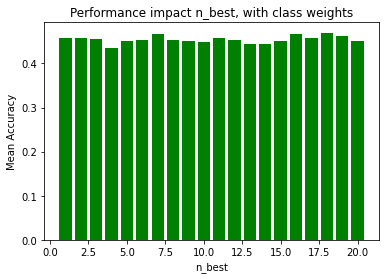

In [10]:
import matplotlib.pyplot as plt
plt.bar(n_best_counts, mean_accs, color='green')
plt.xlabel("n_best")
plt.ylabel("Mean Accuracy")
plt.title("Performance impact n_best, with class weights")
plt.savefig('plots/bm25okapi_n_best_with_class_weights_even_class.png')
plt.show()

In [37]:
accuracies = perform_runs(95, N_BEST, CLASS_WEIGHTS)

Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
Run 10
Run 11
Run 12
Run 13
Run 14
Run 15
Run 16
Run 17
Run 18
Run 19
Run 20
Run 21
Run 22
Run 23
Run 24
Run 25
Run 26
Run 27
Run 28
Run 29
Run 30
Run 31
Run 32
Run 33
Run 34
Run 35
Run 36
Run 37
Run 38
Run 39
Run 40
Run 41
Run 42
Run 43
Run 44
Run 45
Run 46
Run 47
Run 48
Run 49
Run 50
Run 51
Run 52
Run 53
Run 54
Run 55
Run 56
Run 57
Run 58
Run 59
Run 60
Run 61
Run 62
Run 63
Run 64
Run 65
Run 66
Run 67
Run 68
Run 69
Run 70
Run 71
Run 72
Run 73
Run 74
Run 75
Run 76
Run 77
Run 78
Run 79
Run 80
Run 81
Run 82
Run 83
Run 84
Run 85
Run 86
Run 87
Run 88
Run 89
Run 90
Run 91
Run 92
Run 93
Run 94


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

total = len(accuracies)
mean = sum(accuracies)/total

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(sorted(accuracies), label='Model accuracies')
plt.axhline(y=0.33, color='r', linestyle='-', label='Random guess')
plt.axhline(y=mean, color='orange', linestyle='-', label='Mean accuracy')
ax.text(-0.02, mean, "{:.2f}".format(mean), color='orange', ha="right", va="center",
        transform=ax.get_yaxis_transform())
plt.ylabel('Model Accuracies')
plt.title(f"Accuracies of {total} runs, with class weights, 7 best")
plt.legend(loc="lower right", borderaxespad=0)
plt.savefig(PATH_PERFORMANCE_GRAPH)
plt.show()

In [55]:
# Random guess accuracy
import numpy.random
lookup_docs, test_docs, lookup_labels, test_labels = corpus_split(20)
preds = numpy.random.choice(lookup_labels, len(test_labels))
correct = preds == test_labels
print(f"Accuracy class weight predictions: {correct.sum() / correct.size}")
preds = numpy.random.choice([0], len(test_labels))
correct = preds == test_labels
print(f"Accuracy 0,1: {correct.sum() / correct.size}")

Accuracy class weight predictions: 0.23333333333333334
Accuracy 0,1: 0.3333333333333333


<ipython-input-52-55f5eae5686e>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  train_x = np.array(train['text'].tolist())
<ipython-input-52-55f5eae5686e>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  test_x = np.array(test['text'].tolist())


In [56]:
np.bincount(lookup_labels)

array([256, 106,  70])